Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### 1. Importing all the important libraries



In [1]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

### 2. Read data from Google Drive

Google Drive : To read data from Google Drive, uncomment the next 4 cells and comment the 5th cell.

Local Drive : Comment the next 4 cells and uncomment the 5th cell.

In [3]:
# Mount the Google Drive
#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)
#!ls "/content/gdrive/MyDrive"

In [4]:
# Unzip the CNN folder contents to a new folder
#!unzip -u "/content/gdrive/MyDrive/CNN_assignment.zip" -d "/content/gdrive/MyDrive/CNN_assignment"

# Again read the contents in Google drive and check whether the new folder is created
#!ls "/content/gdrive/MyDrive"

In [5]:
# Get the contents in CNN_Assignment folder
#PATH = '/content/gdrive/MyDrive/CNN_assignment'
#os.listdir(PATH)

In [6]:
#PATH = '/content/gdrive/MyDrive/CNN_assignment'+ '/' + 'Skin cancer ISIC The International Skin Imaging Collaboration'
#os.listdir(PATH)

In [7]:
# Append the folder to PATH variable to get the contents in the folder
PATH = '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration'
os.listdir(PATH)

['Test', 'Train']

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(PATH + "/" + "Train")
data_dir_test = pathlib.Path(PATH + "/" + "Test")
print("Training Path : ", data_dir_train)
print("Test Path : ", data_dir_test)

Training Path :  /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Test Path :  /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### 3. Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180
seed=123

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', class_names=None,
    color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width), shuffle=True, seed=seed,
    validation_split=0.2, subset="training", interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', class_names=None,
    color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width), shuffle=True, seed=seed,
    validation_split=0.2, subset="validation", interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names_len = len(class_names)
print(class_names)
print("Number of classes are", class_names_len)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes are 9


### 4. Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

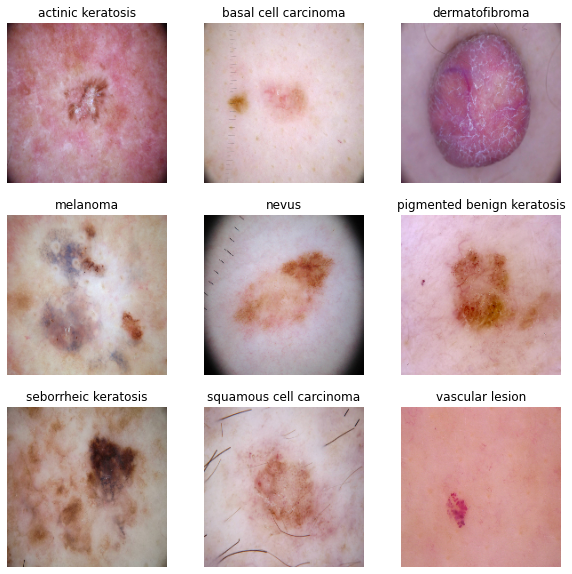

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for i in range(class_names_len):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
input_shape = (img_width, img_height, 3)
# Model - 1 with 3 con2d layers, max layers and dropout layers followed by Flatten layer and 2 dense layers
model_1 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)])

model_1.add(Conv2D(32, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))

model_1.add(Flatten())

model_1.add(Dense(128, activation='relu'))

model_1.add(Dense(class_names_len, activation='softmax'))

In [17]:
#compile model
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


epochs = 20
#fit the model 
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 41s 617ms/step - loss: 2.2129 - accuracy: 0.1970 - val_loss: 2.0542 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 38s 672ms/step - loss: 1.8763 - accuracy: 0.3058 - val_loss: 1.7091 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 36s 635ms/step - loss: 1.6949 - accuracy: 0.3867 - val_loss: 1.6135 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 36s 645ms/step - loss: 1.5508 - accuracy: 0.4581 - val_loss: 1.6744 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 36s 652ms/step - loss: 1.4606 - accuracy: 0.4927 - val_loss: 1.4987 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 36s 648ms/step - loss: 1.4041 - accuracy: 0.5134 - val_loss: 1.3933 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 36s 651ms/step - loss: 1.3471 - accuracy: 0.5279 - val_loss: 1.3511 - val_accuracy: 0.5324

In [18]:
# Model - 1 with 2 con2d layers, max layers and dropout layers followed by Flatten layer and 2 dense layers
model_2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)])

model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(128, activation='relu'))

model_2.add(Dense(class_names_len, activation='softmax'))

In [19]:
#compile model
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#fit the model 
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 502ms/step - loss: 2.4830 - accuracy: 0.1892 - val_loss: 2.0148 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 27s 491ms/step - loss: 1.9277 - accuracy: 0.2913 - val_loss: 1.8694 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 28s 499ms/step - loss: 1.6373 - accuracy: 0.4252 - val_loss: 1.7038 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 27s 483ms/step - loss: 1.4796 - accuracy: 0.4777 - val_loss: 1.5476 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 28s 505ms/step - loss: 1.3488 - accuracy: 0.5312 - val_loss: 1.4787 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 28s 493ms/step - loss: 1.2546 - accuracy: 0.5374 - val_loss: 1.4283 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 28s 500ms/step - loss: 1.1809 - accuracy: 0.5887 - val_loss: 1.4928 - val_accuracy: 0.5078

In [20]:
# Model - 1 with 3 con2d layers and max layers  followed by Flatten layer and 2 dense layers - No dropout layer

model_3 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)])

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Flatten())

model_3.add(Dense(128, activation='relu'))

model_3.add(Dense(class_names_len, activation='softmax'))

In [21]:
#compile model
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#fit the model 
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 502ms/step - loss: 1.9553 - accuracy: 0.2907 - val_loss: 1.7420 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 28s 503ms/step - loss: 1.6223 - accuracy: 0.4252 - val_loss: 1.5326 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 29s 508ms/step - loss: 1.4943 - accuracy: 0.4760 - val_loss: 1.4816 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 29s 520ms/step - loss: 1.4331 - accuracy: 0.4916 - val_loss: 1.4350 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 28s 499ms/step - loss: 1.3502 - accuracy: 0.5251 - val_loss: 1.3698 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 28s 505ms/step - loss: 1.2842 - accuracy: 0.5413 - val_loss: 1.5249 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 29s 521ms/step - loss: 1.2051 - accuracy: 0.5625 - val_loss: 1.5178 - val_accuracy: 0.4541

In [22]:
### Your code goes here
#model = tf.keras.Sequential([
 # layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
 # layers.Conv2D(32, 3, activation='relu'),
 # layers.MaxPooling2D(),
  
 # layers.Conv2D(64, 3, activation='relu'),
 # layers.MaxPooling2D(),
 # layers.Dropout(0.2),

 # layers.Conv2D(64, 3, activation='relu'),
 # layers.MaxPooling2D(),

 # layers.Flatten(),
 # layers.Dense(128, activation='relu'),
 # layers.Dense(class_names_len, activation='softmax')
 # ])

# Model - 1 with 2 con2d layers and max layers  followed by Flatten layer and 2 dense layers - No dropout layer

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)])

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(class_names_len, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [23]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 118336)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [25]:
# Fit the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 31s 536ms/step - loss: 2.3009 - accuracy: 0.2952 - val_loss: 1.6629 - val_accuracy: 0.3893
Epoch 2/20
56/56 [==============================] - 31s 558ms/step - loss: 1.6314 - accuracy: 0.4208 - val_loss: 1.5577 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 32s 580ms/step - loss: 1.4925 - accuracy: 0.4760 - val_loss: 1.5975 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 32s 566ms/step - loss: 1.3920 - accuracy: 0.5206 - val_loss: 1.4830 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 32s 568ms/step - loss: 1.2138 - accuracy: 0.5731 - val_loss: 1.3921 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 32s 575ms/step - loss: 1.0795 - accuracy: 0.6272 - val_loss: 1.5144 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 34s 604ms/step - loss: 0.9980 - accuracy: 0.6445 - val_loss: 1.7197 - val_accuracy: 0.4944

### Train the model

### Visualizing training results

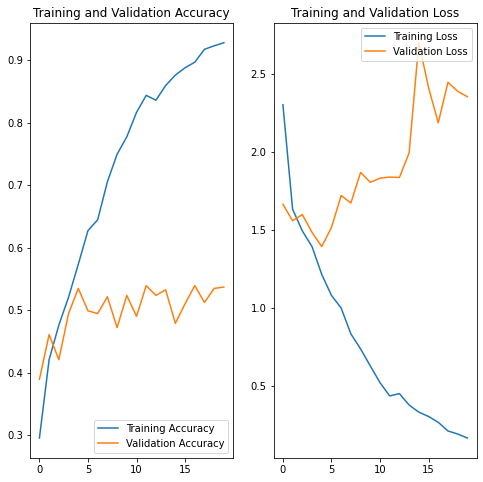

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

[link text](https://)### Write your findings here

Model is clearly overfit here because of two reasons :

1.   A large difference in accuracy between training and validation sets ( (Training : 92.35, validation : 51.23)
2.   A large difference in Loss between training and validation sets ( (Training : 0.19, validation : 2.71) 

Since the training accuracy is much more than test accuracy, I can conclude that the model memorized the input data and to fix this, try transforming the data (Increase variance)


In [27]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])



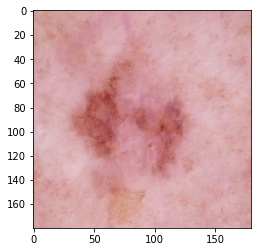

In [28]:
# Get an image
image, label = next(iter(train_ds))
plt.imshow(image[0].numpy().astype("uint8"))

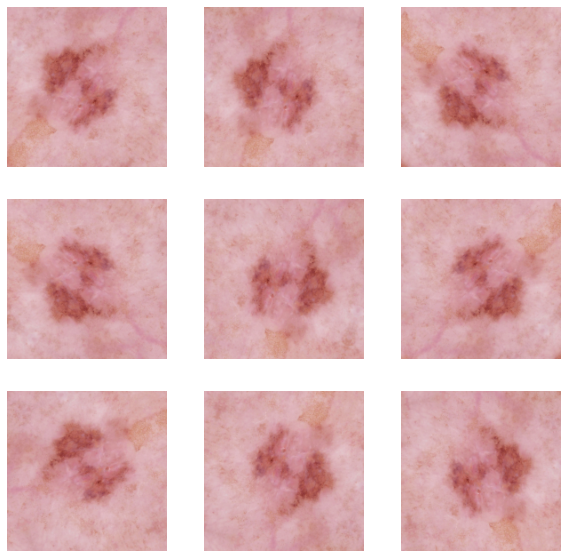

In [29]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")
    

### Todo:
### Create the model, compile and train the model


In [30]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)])

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(class_names_len, activation='softmax'))

In [31]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 43, 43, 64)       

In [33]:
# Fit the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 45s 786ms/step - loss: 2.6488 - accuracy: 0.2422 - val_loss: 1.9536 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 36s 635ms/step - loss: 1.7345 - accuracy: 0.3923 - val_loss: 1.5442 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 36s 637ms/step - loss: 1.4886 - accuracy: 0.4777 - val_loss: 1.4452 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 35s 627ms/step - loss: 1.4721 - accuracy: 0.4816 - val_loss: 1.5540 - val_accuracy: 0.4385
Epoch 5/20
56/56 [==============================] - 35s 626ms/step - loss: 1.3916 - accuracy: 0.5123 - val_loss: 1.3936 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 35s 627ms/step - loss: 1.3959 - accuracy: 0.5134 - val_loss: 1.4728 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 37s 663ms/step - loss: 1.3522 - accuracy: 0.5190 - val_loss: 1.4013 - val_accuracy: 0.5145

In [34]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)])

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(class_names_len, activation='softmax'))

### Compiling the model

In [35]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 87, 87, 64)       

### Training the model

In [36]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 53s 925ms/step - loss: 3.1572 - accuracy: 0.1819 - val_loss: 2.1270 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 56s 995ms/step - loss: 2.0194 - accuracy: 0.2305 - val_loss: 2.0702 - val_accuracy: 0.2886
Epoch 3/20
56/56 [==============================] - 49s 866ms/step - loss: 1.9036 - accuracy: 0.2997 - val_loss: 2.0135 - val_accuracy: 0.2595
Epoch 4/20
56/56 [==============================] - 53s 938ms/step - loss: 1.8256 - accuracy: 0.3192 - val_loss: 1.7737 - val_accuracy: 0.3602
Epoch 5/20
56/56 [==============================] - 46s 819ms/step - loss: 1.6191 - accuracy: 0.4235 - val_loss: 1.7109 - val_accuracy: 0.4407
Epoch 6/20
56/56 [==============================] - 45s 801ms/step - loss: 1.5053 - accuracy: 0.4721 - val_loss: 1.6300 - val_accuracy: 0.4541
Epoch 7/20
56/56 [==============================] - 42s 753ms/step - loss: 1.4011 - accuracy: 0.5095 - val_loss: 1.5597 - val_accuracy: 0.5056

### Visualizing the results

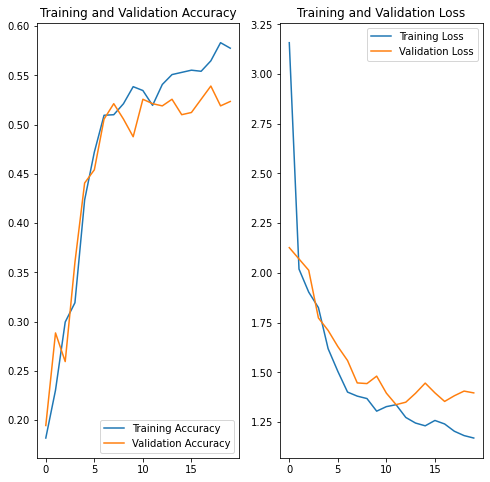

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

##### No Overfit / Underfit but only low value of accuracy

1.   There is no evidence of overfit or underfit as there is no huge difference in accuracies between training and validation sets. Training is at 57.53 and validation is at 54.14.
2.   The problem with this current model is the low value of accuracy. 

Earlier model had better accuracy but it was overfit and the current model is not overfit but having lesss accuracy, so , in the next model, we try to increase accuracy without overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
## Your code goes here.
folders = ([name for name in os.listdir(data_dir_train)
            if os.path.isdir(os.path.join(data_dir_train, name))]) # get all directories 
for folder in folders:
    print(folder,len(list((data_dir_train / folder).glob('*.jpg'))), sep = " : ")

melanoma : 438
pigmented benign keratosis : 462
nevus : 357
basal cell carcinoma : 376
actinic keratosis : 114
squamous cell carcinoma : 181
vascular lesion : 139
seborrheic keratosis : 77
dermatofibroma : 95


In [39]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010550.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0011128.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010587.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010034.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000555.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_

In [40]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [41]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [42]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df.head(5)

,Path,Label
0,/Users/abalisetty/Documents/UpGrad/Python/Mach...,melanoma
1,/Users/abalisetty/Documents/UpGrad/Python/Mach...,melanoma
2,/Users/abalisetty/Documents/UpGrad/Python/Mach...,melanoma
3,/Users/abalisetty/Documents/UpGrad/Python/Mach...,melanoma
4,/Users/abalisetty/Documents/UpGrad/Python/Mach...,melanoma


In [43]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
X , y = original_df["Path"], original_df["Label"]
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


<BarContainer object of 9 artists>

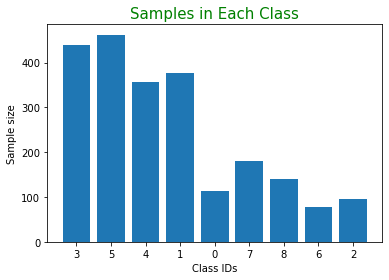

In [44]:
plt.xticks(range(len(counter.keys())), counter.keys())
plt.xlabel('Class IDs')
plt.ylabel('Sample size')
plt.title('Samples in Each Class', fontsize= 15, fontweight= 15, color = 'g')
plt.bar(range(len(counter.keys())), counter.values()) 

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

##### Class with least number of samples :  "seborrheic keratosis" (class-6) with 77 samples
##### Class with highest number of samples :  "pigmented benign keratosis" (class-5) with 462 samples dominate the data in terms proportionate number of sample.

Classes and their sample count is as follows : 
1.   pigmented benign keratosis : 462
2.   melanoma : 438
3.   basal cell carcinoma : 376
4.   nevus : 357
5.   squamous cell carcinoma : 181
6.   vascular lesion : 139
7.   actinic keratosis : 114
8.   dermatofibroma : 95
9.   seborrheic keratosis : 77

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [45]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [46]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F836AF0C280>:   2%|▏         | 11/500 [00:00<00:58,  8.35 Samples/s]                  

Initialised with 114 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8390E94070>: 100%|██████████| 500/500 [00:06<00:00, 74.97 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F836F18EFD0>:   1%|          | 3/500 [00:00<01:06,  7.45 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82DCBDED90>: 100%|██████████| 500/500 [00:08<00:00, 60.97 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82DBCB1DF0>:   1%|          | 6/500 [00:00<01:04,  7.70 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82DCBE5910>: 100%|██████████| 500/500 [00:08<00:00, 60.36 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F837E27DF70>:   0%|          | 2/500 [00:00<00:30, 16.58 Samples/s]

Initialised with 438 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F837B3D43D0>: 100%|██████████| 500/500 [00:40<00:00, 12.49 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F82BCBA5820>: 100%|██████████| 500/500 [00:39<00:00, 12.70 Samples/s]                    
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F837B3B1640>:   1%|▏         | 7/500 [00:00<01:10,  6.95 Samples/s]                  

Initialised with 462 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F837BCDB790>: 100%|██████████| 500/500 [00:06<00:00, 73.06 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F82DBCBAAC0>: 100%|██████████| 500/500 [00:17<00:00, 27.80 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F837B3B1B50>:   0%|          | 1/500 [00:00<01:37,  5.13 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F837BCE7A60>: 100%|██████████| 500/500 [00:07<00:00, 69.07 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82DBB81670>: 100%|██████████| 500/500 [00:06<00:00, 76.97 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [47]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [48]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000412.jpg_ccf44c06-a9fe-4f3b-846f-8e9bf0c59480.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010194.jpg_ae2bc4cd-d93c-46eb-9762-aefd359ed411.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010979.jpg_43cb9218-f983-4b56-9f5f-42901d64e8d9.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/06. Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010532.jpg_70d089fc-5b19-46ab-a826-76f620f8412a.jpg',
 '/Users/abalisetty/Documents/UpGrad/Python/MachineLearning/

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [50]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [51]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [52]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [54]:
data_dir_train=pathlib.Path(PATH + "/" + "Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [56]:

model_f = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)])

model_f.add(Conv2D(32, (3, 3), activation='relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Dropout(0.1))

model_f.add(Conv2D(64, (3, 3), activation='relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Dropout(0.1))

model_f.add(Flatten())

model_f.add(Dense(128, activation='relu'))

model_f.add(Dense(class_names_len, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [57]:
# Compile model
model_f.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Get the summary of the model 
model_f.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 87, 87, 64)       

#### **Todo:**  Train your model

In [58]:
epochs = 50
## Your code goes here, use 30 epochs.
history = model_f.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 157s 921ms/step - loss: 2.4068 - accuracy: 0.2485 - val_loss: 1.7916 - val_accuracy: 0.3460
Epoch 2/50
169/169 [==============================] - 146s 861ms/step - loss: 1.6223 - accuracy: 0.3843 - val_loss: 1.6056 - val_accuracy: 0.3979
Epoch 3/50
169/169 [==============================] - 148s 871ms/step - loss: 1.5498 - accuracy: 0.4026 - val_loss: 1.4998 - val_accuracy: 0.4321
Epoch 4/50
169/169 [==============================] - 132s 776ms/step - loss: 1.4518 - accuracy: 0.4488 - val_loss: 1.4194 - val_accuracy: 0.4729
Epoch 5/50
169/169 [==============================] - 134s 790ms/step - loss: 1.3844 - accuracy: 0.4659 - val_loss: 1.4784 - val_accuracy: 0.4410
Epoch 6/50
169/169 [==============================] - 137s 808ms/step - loss: 1.3342 - accuracy: 0.4905 - val_loss: 1.3522 - val_accuracy: 0.4714
Epoch 7/50
169/169 [==============================] - 151s 891ms/step - loss: 1.2977 - accuracy: 0.5007 - val_loss: 1.2525 -

#### **Todo:**  Visualize the model results

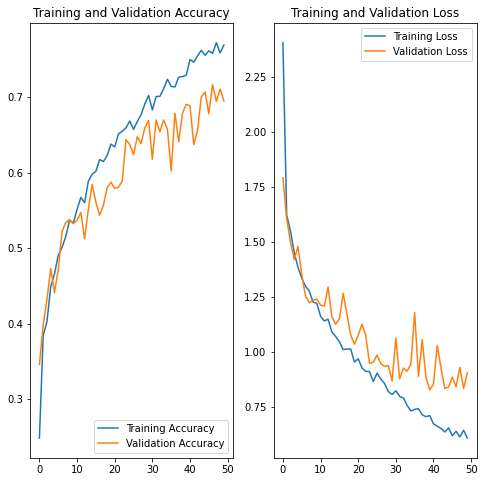

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [136]:
### Rebalance helped the model to get rid of Overfitting/Underfitting as 
#### Training & Validation accuracies are close together (Training Accuracy-77 ; Validation Accuracy-72)
